# IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import datetime, os
from tensorflow.keras.layers import Cropping1D,Embedding, Flatten, Dense, concatenate, Dropout,GlobalAveragePooling1D,GlobalMaxPooling1D,LSTM
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Importing the Dataset

## Read and Explore the Data

In [4]:
#Import the data set
df = pd.read_csv('Reviews3.csv')

In [5]:
# see few TOP rows of the imported dataset
df.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5
1,2,B00813GRG4,A1D87F6ZCVE5NK,0,0,1
2,3,B000LQOCH0,ABXLMWJIXXAIN,1,1,4
3,4,B000UA0QIQ,A395BORC6FGVXV,3,3,2
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5


In [6]:
# Dropping the columns
df = df.drop(['Id','HelpfulnessNumerator','HelpfulnessDenominator'], axis = 1) 


In [7]:
# see few BOTTOM rows of the imported dataset
df.tail()

,ProductId,UserId,Score
568449,B001EO7N10,A28KG5XORO54AY,5
568450,B003S1WTCU,A3I8AFVPEE8KI5,2
568451,B004I613EE,A121AA1GQV751Z,5
568452,B004I613EE,A3IBEVCTXKNOH,5
568453,B001LR2CU2,A3LGQPJCZVL9UC,5


In [9]:
#Check Data types
df.dtypes

ProductId    object
UserId       object
Score         int64
dtype: object

In [10]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 ProductId    0
UserId       0
Score        0
dtype: int64


In [11]:
# find minimum and maximum ratings 

def find_min_max_rating():
    print('The minimum rating is: %d' %(df['Score'].min()))
    print('The maximum rating is: %d' %(df['Score'].max()))
    
find_min_max_rating() 

The minimum rating is: 1
The maximum rating is: 5


### Ratings are on scale of 1 - 5


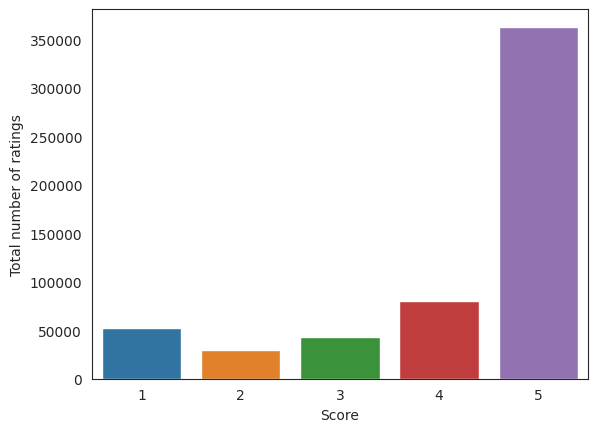

In [13]:
# Check the distribution of ratings
with sns.axes_style('white'):
    g = sns.countplot(data=df, x="Score")
    g.set_ylabel("Total number of ratings")


In [14]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['UserId'].nunique())
print('Number of unique ITEMS in Raw data = ', df['ProductId'].nunique())

Number of unique USERS in Raw data =  256059
Number of unique ITEMS in Raw data =  74258


### Take subset of dataset to make it less sparse/more dense. ( For example, keep the users only who has given 50 or more number of ratings )

In [15]:
# Top 10 users based on rating
most_rated = df.groupby('UserId').size().sort_values(ascending=False)[:5]
most_rated

UserId
A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
dtype: int64

### Data model preparation as per requirement on number of minimum ratings


In [21]:
counts = df['UserId'].value_counts()
df_final = df[df['UserId'].isin(counts[counts >= 40].index)]

In [22]:
counts

UserId
A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
                 ... 
A2O8OFVSTO9PF3      1
A1C6KXG47GAQ7B      1
A1TU5DS89D9OVD      1
A3N005JS5FG5FI      1
A3LGQPJCZVL9UC      1
Name: count, Length: 256059, dtype: int64

In [23]:
df_final.head()

,ProductId,UserId,Score
14,B001GVISJM,A2MUGFV2TDQ47K,5
18,B001GVISJM,A2A9X58G2GTBLP,5
44,B001EO5QW8,A2G7B7FKP2O2PU,5
46,B001EO5QW8,AQLL2R1PPR46X,5
109,B001REEG6C,AY12DBB0U420B,5


In [24]:
print('Number of users who have rated 40 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['UserId'].nunique())
print('Number of unique ITEMS in final data = ', df_final['ProductId'].nunique())

Number of users who have rated 40 or more items = 30130
Number of unique USERS in final data =  430
Number of unique ITEMS in final data =  13227


-------------------

### Split the data randomly into train and test dataset.

In [47]:
# Split the data into training and test sets
#using the df_final cause the df data is too much data and the memory can't load the training
train_data, test_data = train_test_split(df_final, test_size=0.1, random_state=0)

In [48]:
# Create a dictionary mapping user IDs to unique indices
user_ids = df_final['UserId'].unique()
user_id_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
index_to_user_id = {index: user_id for index, user_id in enumerate(user_ids)}

# Create a dictionary mapping product IDs to unique indices
product_ids = df_final['ProductId'].unique()
product_id_to_index = {product_id: index for index, product_id in enumerate(product_ids)}
index_to_product_id = {index: product_id for index, product_id in enumerate(product_ids)}

# Convert user and product IDs to indices and food names in the dataframe
train_data['user_index'] = train_data['UserId'].map(user_id_to_index)
train_data['product_index'] = train_data['ProductId'].map(product_id_to_index)

test_data['user_index'] = test_data['UserId'].map(user_id_to_index)
test_data['product_index'] = test_data['ProductId'].map(product_id_to_index)

## DATA

In [49]:
# Prepare the training data
x_train_user = train_data['user_index'].values
x_train_product = train_data['product_index'].values
x_train = np.concatenate((x_train_user.reshape(-1, 1), x_train_product.reshape(-1, 1)), axis=1)
y_train = train_data['Score'].values

#make the y_train is scaled
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1))

# Prepare the test data
x_test_user = test_data['user_index'].values
x_test_product = test_data['product_index'].values
x_test = np.concatenate((x_test_user.reshape(-1, 1), x_test_product.reshape(-1, 1)), axis=1)
y_test = test_data['Score'].values

y_test = scaler.fit_transform(y_test.reshape(-1, 1))

In [53]:
num_products

13227

In [76]:
# Set the input shape
num_users = len(user_ids)
num_products = len(product_ids)
embedding_dim = 512

# Create the embedding layer
embedding_layer = Embedding(num_users + num_products +1, embedding_dim, input_length=2)

# Create the model
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

In [81]:
# Load tensorboard 
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [82]:
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 15016), started 2 days, 6:30:59 ago. (Use '!kill 15016' to kill it.)

In [83]:
# Setup for tensorboard
from datetime import datetime
import os
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [85]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 2, 512)            6992896   
                                                                 
 lstm_14 (LSTM)              (None, 2, 128)            328192    
                                                                 
 lstm_15 (LSTM)              (None, 2, 128)            131584    
                                                                 
 lstm_16 (LSTM)              (None, 128)               131584    
                                                                 
 dense_36 (Dense)            (None, 128)               16512     
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 128)             

In [84]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
delta = 1.0

# Compile the model
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta=delta))

# Train the model
history = model.fit(x_train, y_train, epochs=1000, batch_size=64, validation_split=0.1,callbacks=[tensorboard_callback])

Epoch 1/1000
382/382 [==============================] - 10s 18ms/step - loss: 0.0447 - val_loss: 0.0338
Epoch 2/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0316 - val_loss: 0.0332
Epoch 3/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0224 - val_loss: 0.0316
Epoch 4/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0175 - val_loss: 0.0318
Epoch 5/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0145 - val_loss: 0.0320
Epoch 6/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0125 - val_loss: 0.0326
Epoch 7/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0109 - val_loss: 0.0348
Epoch 8/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0100 - val_loss: 0.0341
Epoch 9/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0091 - val_loss: 0.0314
Epoch 10/1000
382/382 [==============================] - 6s 16ms/step - 

Epoch 80/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0022 - val_loss: 0.0376
Epoch 81/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0022 - val_loss: 0.0360
Epoch 82/1000
382/382 [==============================] - 6s 17ms/step - loss: 0.0022 - val_loss: 0.0368
Epoch 83/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0021 - val_loss: 0.0369
Epoch 84/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0021 - val_loss: 0.0373
Epoch 85/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0022 - val_loss: 0.0369
Epoch 86/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0023 - val_loss: 0.0363
Epoch 87/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0021 - val_loss: 0.0366
Epoch 88/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0022 - val_loss: 0.0373
Epoch 89/1000
382/382 [==============================] - 6s 15ms

382/382 [==============================] - 6s 15ms/step - loss: 0.0022 - val_loss: 0.0389
Epoch 159/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0021 - val_loss: 0.0388
Epoch 160/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0021 - val_loss: 0.0393
Epoch 161/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0021 - val_loss: 0.0381
Epoch 162/1000
382/382 [==============================] - 6s 14ms/step - loss: 0.0021 - val_loss: 0.0379
Epoch 163/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0021 - val_loss: 0.0379
Epoch 164/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0021 - val_loss: 0.0391
Epoch 165/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0020 - val_loss: 0.0394
Epoch 166/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0022 - val_loss: 0.0377
Epoch 167/1000
382/382 [==============================] - 6s 15ms/step

382/382 [==============================] - 7s 17ms/step - loss: 0.0019 - val_loss: 0.0379
Epoch 237/1000
382/382 [==============================] - 6s 17ms/step - loss: 0.0019 - val_loss: 0.0381
Epoch 238/1000
382/382 [==============================] - 6s 17ms/step - loss: 0.0020 - val_loss: 0.0374
Epoch 239/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0020 - val_loss: 0.0389
Epoch 240/1000
382/382 [==============================] - 6s 17ms/step - loss: 0.0020 - val_loss: 0.0380
Epoch 241/1000
382/382 [==============================] - 7s 18ms/step - loss: 0.0020 - val_loss: 0.0375
Epoch 242/1000
382/382 [==============================] - 6s 17ms/step - loss: 0.0021 - val_loss: 0.0373
Epoch 243/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0021 - val_loss: 0.0368
Epoch 244/1000
382/382 [==============================] - 7s 18ms/step - loss: 0.0021 - val_loss: 0.0379
Epoch 245/1000
382/382 [==============================] - 6s 16ms/step

382/382 [==============================] - 6s 15ms/step - loss: 0.0020 - val_loss: 0.0391
Epoch 315/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0020 - val_loss: 0.0391
Epoch 316/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0019 - val_loss: 0.0392
Epoch 317/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0019 - val_loss: 0.0397
Epoch 318/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0019 - val_loss: 0.0391
Epoch 319/1000
382/382 [==============================] - 6s 17ms/step - loss: 0.0019 - val_loss: 0.0393
Epoch 320/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0019 - val_loss: 0.0407
Epoch 321/1000
382/382 [==============================] - 6s 17ms/step - loss: 0.0019 - val_loss: 0.0402
Epoch 322/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0019 - val_loss: 0.0390
Epoch 323/1000
382/382 [==============================] - 6s 16ms/step

382/382 [==============================] - 6s 16ms/step - loss: 0.0020 - val_loss: 0.0379
Epoch 393/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0020 - val_loss: 0.0376
Epoch 394/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0020 - val_loss: 0.0368
Epoch 395/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0020 - val_loss: 0.0384
Epoch 396/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0020 - val_loss: 0.0379
Epoch 397/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0020 - val_loss: 0.0380
Epoch 398/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0020 - val_loss: 0.0375
Epoch 399/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0020 - val_loss: 0.0374
Epoch 400/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0019 - val_loss: 0.0386
Epoch 401/1000
382/382 [==============================] - 6s 16ms/step

382/382 [==============================] - 6s 15ms/step - loss: 0.0020 - val_loss: 0.0370
Epoch 471/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0020 - val_loss: 0.0369
Epoch 472/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0019 - val_loss: 0.0375
Epoch 473/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0019 - val_loss: 0.0375
Epoch 474/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0019 - val_loss: 0.0372
Epoch 475/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0019 - val_loss: 0.0375
Epoch 476/1000
382/382 [==============================] - 6s 16ms/step - loss: 0.0019 - val_loss: 0.0373
Epoch 477/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0019 - val_loss: 0.0380
Epoch 478/1000
382/382 [==============================] - 6s 15ms/step - loss: 0.0019 - val_loss: 0.0382
Epoch 479/1000
382/382 [==============================] - 6s 15ms/step

382/382 [==============================] - 8s 20ms/step - loss: 0.0019 - val_loss: 0.0391
Epoch 549/1000
382/382 [==============================] - 8s 22ms/step - loss: 0.0019 - val_loss: 0.0396
Epoch 550/1000
382/382 [==============================] - 7s 19ms/step - loss: 0.0019 - val_loss: 0.0380
Epoch 551/1000
382/382 [==============================] - 8s 22ms/step - loss: 0.0019 - val_loss: 0.0391
Epoch 552/1000
382/382 [==============================] - 8s 21ms/step - loss: 0.0019 - val_loss: 0.0381
Epoch 553/1000
382/382 [==============================] - 7s 19ms/step - loss: 0.0019 - val_loss: 0.0392
Epoch 554/1000
382/382 [==============================] - 8s 22ms/step - loss: 0.0019 - val_loss: 0.0386
Epoch 555/1000
382/382 [==============================] - 8s 21ms/step - loss: 0.0019 - val_loss: 0.0393
Epoch 556/1000
382/382 [==============================] - 7s 17ms/step - loss: 0.0019 - val_loss: 0.0393
Epoch 557/1000
382/382 [==============================] - 8s 21ms/step

382/382 [==============================] - 8s 20ms/step - loss: 0.0019 - val_loss: 0.0383
Epoch 627/1000
382/382 [==============================] - 8s 22ms/step - loss: 0.0019 - val_loss: 0.0384
Epoch 628/1000
382/382 [==============================] - 8s 21ms/step - loss: 0.0019 - val_loss: 0.0392
Epoch 629/1000
382/382 [==============================] - 7s 19ms/step - loss: 0.0019 - val_loss: 0.0396
Epoch 630/1000
382/382 [==============================] - 7s 17ms/step - loss: 0.0019 - val_loss: 0.0391
Epoch 631/1000
382/382 [==============================] - 8s 20ms/step - loss: 0.0019 - val_loss: 0.0394
Epoch 632/1000
382/382 [==============================] - 8s 21ms/step - loss: 0.0019 - val_loss: 0.0402
Epoch 633/1000
382/382 [==============================] - 8s 22ms/step - loss: 0.0019 - val_loss: 0.0401
Epoch 634/1000
382/382 [==============================] - 7s 19ms/step - loss: 0.0019 - val_loss: 0.0392
Epoch 635/1000
382/382 [==============================] - 8s 22ms/step

382/382 [==============================] - 8s 20ms/step - loss: 0.0018 - val_loss: 0.0381
Epoch 705/1000
382/382 [==============================] - 8s 20ms/step - loss: 0.0019 - val_loss: 0.0373
Epoch 706/1000
382/382 [==============================] - 8s 21ms/step - loss: 0.0018 - val_loss: 0.0373
Epoch 707/1000
382/382 [==============================] - 8s 22ms/step - loss: 0.0018 - val_loss: 0.0386
Epoch 708/1000
382/382 [==============================] - 8s 21ms/step - loss: 0.0018 - val_loss: 0.0382
Epoch 709/1000
382/382 [==============================] - 8s 21ms/step - loss: 0.0018 - val_loss: 0.0377
Epoch 710/1000
382/382 [==============================] - 8s 21ms/step - loss: 0.0018 - val_loss: 0.0385
Epoch 711/1000
382/382 [==============================] - 8s 20ms/step - loss: 0.0018 - val_loss: 0.0379
Epoch 712/1000
382/382 [==============================] - 7s 18ms/step - loss: 0.0019 - val_loss: 0.0377
Epoch 713/1000
382/382 [==============================] - 8s 20ms/step

382/382 [==============================] - 7s 18ms/step - loss: 0.0019 - val_loss: 0.0392
Epoch 783/1000
382/382 [==============================] - 7s 18ms/step - loss: 0.0019 - val_loss: 0.0391
Epoch 784/1000
382/382 [==============================] - 7s 19ms/step - loss: 0.0019 - val_loss: 0.0387
Epoch 785/1000
382/382 [==============================] - 8s 20ms/step - loss: 0.0019 - val_loss: 0.0395
Epoch 786/1000
382/382 [==============================] - 8s 20ms/step - loss: 0.0019 - val_loss: 0.0397
Epoch 787/1000
382/382 [==============================] - 9s 22ms/step - loss: 0.0019 - val_loss: 0.0397
Epoch 788/1000
382/382 [==============================] - 7s 18ms/step - loss: 0.0020 - val_loss: 0.0400
Epoch 789/1000
382/382 [==============================] - 7s 18ms/step - loss: 0.0019 - val_loss: 0.0387
Epoch 790/1000
382/382 [==============================] - 7s 19ms/step - loss: 0.0019 - val_loss: 0.0394
Epoch 791/1000
382/382 [==============================] - 7s 19ms/step

382/382 [==============================] - 8s 22ms/step - loss: 0.0019 - val_loss: 0.0392
Epoch 861/1000
382/382 [==============================] - 8s 22ms/step - loss: 0.0019 - val_loss: 0.0388
Epoch 862/1000
382/382 [==============================] - 8s 21ms/step - loss: 0.0019 - val_loss: 0.0385
Epoch 863/1000
382/382 [==============================] - 8s 22ms/step - loss: 0.0019 - val_loss: 0.0390
Epoch 864/1000
382/382 [==============================] - 7s 19ms/step - loss: 0.0019 - val_loss: 0.0395
Epoch 865/1000
382/382 [==============================] - 8s 21ms/step - loss: 0.0019 - val_loss: 0.0399
Epoch 866/1000
382/382 [==============================] - 8s 22ms/step - loss: 0.0019 - val_loss: 0.0396
Epoch 867/1000
382/382 [==============================] - 9s 23ms/step - loss: 0.0019 - val_loss: 0.0389
Epoch 868/1000
382/382 [==============================] - 7s 19ms/step - loss: 0.0019 - val_loss: 0.0400
Epoch 869/1000
382/382 [==============================] - 7s 18ms/step

382/382 [==============================] - 7s 18ms/step - loss: 0.0019 - val_loss: 0.0392
Epoch 939/1000
382/382 [==============================] - 7s 19ms/step - loss: 0.0020 - val_loss: 0.0383
Epoch 940/1000
382/382 [==============================] - 7s 19ms/step - loss: 0.0019 - val_loss: 0.0382
Epoch 941/1000
382/382 [==============================] - 7s 18ms/step - loss: 0.0019 - val_loss: 0.0380
Epoch 942/1000
382/382 [==============================] - 7s 18ms/step - loss: 0.0019 - val_loss: 0.0389
Epoch 943/1000
382/382 [==============================] - 7s 18ms/step - loss: 0.0019 - val_loss: 0.0382
Epoch 944/1000
382/382 [==============================] - 7s 19ms/step - loss: 0.0020 - val_loss: 0.0375
Epoch 945/1000
382/382 [==============================] - 7s 18ms/step - loss: 0.0019 - val_loss: 0.0392
Epoch 946/1000
382/382 [==============================] - 7s 19ms/step - loss: 0.0020 - val_loss: 0.0386
Epoch 947/1000
382/382 [==============================] - 7s 18ms/step

In [90]:
huber = model.evaluate(x_test, y_test)
print(f'Huber loss: {huber}')

95/95 [==============================] - 1s 6ms/step - loss: 0.0394
Huber loss: 0.039393678307533264


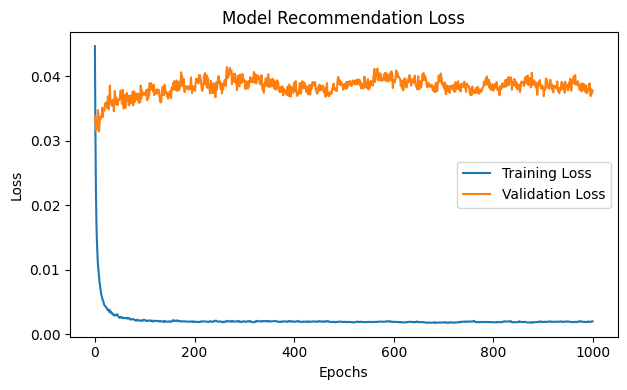

In [88]:
# Plot the model accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Model Recommendation Loss") 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Try Predict Data

In [97]:
# Create a dictionary mapping user IDs to unique indices
user_ids = df_final['UserId'].unique()
user_id_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
index_to_user_id = {index: user_id for index, user_id in enumerate(user_ids)}

# Create a dictionary mapping product IDs to unique indices
product_ids = df_final['ProductId'].unique()
product_id_to_index = {product_id: index for index, product_id in enumerate(product_ids)}
index_to_product_id = {index: product_id for index, product_id in enumerate(product_ids)}

# Convert user and product IDs to indices and food names in the dataframe
df_final['user_index'] = df_final['UserId'].map(user_id_to_index)
df_final['product_index'] = df_final['ProductId'].map(product_id_to_index)

C:\Users\widih\AppData\Local\Temp\ipykernel_9496\3467069078.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['user_index'] = df_final['UserId'].map(user_id_to_index)
C:\Users\widih\AppData\Local\Temp\ipykernel_9496\3467069078.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['product_index'] = df_final['ProductId'].map(product_id_to_index)


In [92]:
uidx= df_final['user_index'].values.astype(np.int64)
pidx = df_final['product_index'].values.astype(np.int64)

In [103]:
# Create a new DataFrame with converted data arrays
df_converted = pd.DataFrame({'UserId': uidx, 'ProductId': pidx, 'Score': 0})

# Create pivot table with the converted DataFrame
final_ratings_matrix = pd.pivot_table(df_converted, index='UserId', columns='ProductId', values='Score')
final_ratings_matrix.fillna(0, inplace=True)

array3 = final_ratings_matrix.reset_index().melt(id_vars=['UserId'], value_vars=final_ratings_matrix.columns)
array3 = array3[['UserId', 'ProductId']].values.astype(np.int64)

In [104]:
specific_user_id = 'A2A9X58G2GTBLP'

# Filter the array3 for the specific user ID
filtered_array3 = array3[array3[:, 0] == user_id_to_index[specific_user_id]]

# Perform predictions
predictions = model.predict(filtered_array3)

# Inverse transform the scaled ratings to get the actual ratings
predictions = scaler.inverse_transform(predictions)

414/414 [==============================] - 2s 3ms/step


In [122]:
#make prediction result to df
df_predicted = pd.DataFrame(filtered_array3, columns=['UserId', 'ProductId'])
df_predicted['PredictedRatings']=predictions
df_predicted

,UserId,ProductId,PredictedRatings
0,1,0,4.893524
1,1,1,4.893524
2,1,2,4.893524
3,1,3,4.893524
4,1,4,4.001530
...,...,...,...
13222,1,13222,4.001530
13223,1,13223,4.893524
13224,1,13224,4.893524
13225,1,13225,4.893524


In [123]:
# Rename the columns back to 'UserId' and 'ProductId'
df_predicted = df_predicted.rename(columns={'UserId': 'user_index', 'ProductId': 'product_index'})

# Convert the user index back to 'UserId'
df_predicted['user_index'] = df_predicted['user_index'].map(index_to_user_id)
# Convert the user index back to 'UserId'
df_predicted['product_index'] = df_predicted['product_index'].map(index_to_product_id)
df_predicted = df_predicted.rename(columns={'user_index': 'UserId',
                                        'product_index':'ProductId'})
df_predicted = df_predicted.sort_values(by='PredictedRatings',ascending=False)
final_result = df_predicted['ProductId'][:10].values
print(f'The 10 ProductId Recommend for user {specific_user_id} : \n {final_result}')

The 10 ProductId Recommend for user A2A9X58G2GTBLP : 
 ['B00061R4AW' 'B004SRFYMK' 'B001EQ4DXE' 'B000G6MBX2' 'B0037NUKWU'
 'B00473Z8RQ' 'B002C1WC88' 'B001ELL9GI' 'B002JEYXSK' 'B003RG9WGM']


# Convert model to TF LITE or H5

In [124]:
export_dir = 'saved_model/1'

In [69]:
model.save(export_dir+'/recommender_model.h5')